In [1]:
import sage_data_client
import matplotlib.pyplot as plt
import pandas as pd
from metpy.calc import dewpoint_from_relative_humidity, wet_bulb_temperature
from metpy.units import units
from PIL import Image
import numpy as np
import datetime
import xarray as xr
import os

from matplotlib.dates import DateFormatter

In [2]:
aqt_global_NEIU = {'conventions': "CF 1.10",
                   'site_ID' : "NEIU",
                  'CAMS_tag' : "CMS-AQT-001",
                  'datastream' : "CMS_aqt580_NEIU_a1",
                  'datalevel' : "a1",
                  'latitude' : 41.9804526,
                  'longitude' : -87.7196038}

var_attrs_aqt = {'pm2.5' : {'standard_name' : 'mole_concentration_of_pm2p5_ambient_aerosol_particles_in_air',
                       'units' : 'ug/m^3'},
            'pm10.0' : {'standard_name' : 'mole_concentration_of_pm10p0_ambient_aerosol_particles_in_air',
                       'units' : 'ug/m^3'},
            'pm1.0' : {'standard_name' : 'mole_concentration_of_pm1p0_ambient_aerosol_particles_in_air',
                       'units' : 'ug/m^3'},
                'no' : {'standard_name' : 'mole_fraction_of_nitrogen_monoxide_in_air',
                       'units' : 'Parts Per Million'},
                'o3' : {'standard_name' : 'mole_fraction_of_ozone_in_air',
                       'units' : 'Parts Per Million'},
                'co' : {'standard_name' : 'mole_fraction_of_carbon_monoxide_in_air',
                       'units' : 'Parts Per Million'},
                'no2' : {'standard_name' : 'mole_fraction_of_nitrogen_dioxide_in_air',
                       'units' : 'Parts Per Million'},
                'temperature': {'standard_name' : 'air_temperature',
                       'units' : 'celsius'},
                'humidity': {'standard_name' : 'relative_humidity',
                       'units' : 'percent'},
                'dewpoint': {'standard_name' : 'dew_point_temperature',
                       'units' : 'celsius'},
                'pressure': {'standard_name' : 'air_pressure',
                       'units' : 'hPa'}}


In [3]:
def ingest_aqt(st, global_attrs, var_attrs):
    hours = 24
    start = st.strftime('%Y-%m-%dT%H:%M:%SZ')
    end = (st + datetime.timedelta(hours=hours)).strftime('%Y-%m-%dT%H:%M:%SZ')

    df_aq = sage_data_client.query(
        start=start,
        end=end, 
        filter={
            "plugin": "registry.sagecontinuum.org/jrobrien/waggle-aqt:0.23.5.04.*",
            "vsn": "W08D"
        }
    )

    pm25 = df_aq[df_aq['name']=='aqt.particle.pm2.5']
    pm10 = df_aq[df_aq['name']=='aqt.particle.pm1']
    pm100 = df_aq[df_aq['name']=='aqt.particle.pm10']

    no = df_aq[df_aq['name']=='aqt.gas.no']
    o3 = df_aq[df_aq['name']=='aqt.gas.ozone']
    no2 = df_aq[df_aq['name']=='aqt.gas.no2']
    co = df_aq[df_aq['name']=='aqt.gas.co']
    aqtemp = df_aq[df_aq['name']=='aqt.env.temp']
    aqhum = df_aq[df_aq['name']=='aqt.env.humidity']
    aqpres = df_aq[df_aq['name']=='aqt.env.pressure']


    pm25['time'] = pd.DatetimeIndex(pm25['timestamp'].values)

    aqvals = pm25.set_index('time')
    aqvals['pm2.5'] = aqvals.value.to_numpy().astype(float)
    aqvals['pm1.0'] = pm10.value.to_numpy().astype(float)
    aqvals['pm10.0'] = pm100.value.to_numpy().astype(float)

    aqvals['no'] = no.value.to_numpy().astype(float)
    aqvals['o3'] = o3.value.to_numpy().astype(float)
    aqvals['no2'] = no2.value.to_numpy().astype(float)
    aqvals['co'] = co.value.to_numpy().astype(float)
    aqvals['temperature'] =  aqtemp.value.to_numpy().astype(float)
    aqvals['humidity'] =  aqhum.value.to_numpy().astype(float)
    aqvals['pressure'] =  aqpres.value.to_numpy().astype(float)
    
    


    dp = dewpoint_from_relative_humidity( aqvals.temperature.to_numpy() * units.degC, 
                                         aqvals.humidity.to_numpy() * units.percent)

    aqvals['dewpoint'] = dp

    _ = aqvals.pop('value')
    _ = aqvals.pop('timestamp')
    
    
    fname = st.strftime('/Users/scollis/data/aqt/CMS_aqt580_NEIU_a1_%Y%m%d_%H%M%SZ.nc')
    valsxr = xr.Dataset.from_dataframe(aqvals)
    valsxr = valsxr.sortby('time')
    
    
    valsxr = valsxr.assign_attrs(global_attrs)
    
    for varname in var_attrs.keys():
        valsxr[varname] = valsxr[varname].assign_attrs(var_attrs[varname])
    
    try:
        os.remove(fname)
    except OSError:
        pass
    
    if valsxr['pm2.5'].shape[0] > 0:
        valsxr.to_netcdf(fname)
    else:
        print('not saving... no data')
    
    #return valsxr



In [4]:

ingest_aqt(datetime.datetime(2023,7,5), aqt_global_NEIU, var_attrs_aqt)


/var/folders/f4/f3jp1t2x0hddhf4vz50gzlnc0000gn/T/ipykernel_15870/1854818838.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pm25['time'] = pd.DatetimeIndex(pm25['timestamp'].values)


In [4]:
start_date = datetime.datetime(2023,8,25)
for i in range(45):
    this_date = start_date + datetime.timedelta(days=i)
    print(this_date)
    try:
        ingest_aqt(this_date, aqt_global_NEIU, var_attrs_aqt)
        print("Succeed")
    except:
        print("Fail")

2023-08-25 00:00:00


/var/folders/f4/f3jp1t2x0hddhf4vz50gzlnc0000gn/T/ipykernel_29318/1854818838.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pm25['time'] = pd.DatetimeIndex(pm25['timestamp'].values)


Succeed
2023-08-26 00:00:00


/var/folders/f4/f3jp1t2x0hddhf4vz50gzlnc0000gn/T/ipykernel_29318/1854818838.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pm25['time'] = pd.DatetimeIndex(pm25['timestamp'].values)


Succeed
2023-08-27 00:00:00


/var/folders/f4/f3jp1t2x0hddhf4vz50gzlnc0000gn/T/ipykernel_29318/1854818838.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pm25['time'] = pd.DatetimeIndex(pm25['timestamp'].values)


Succeed
2023-08-28 00:00:00


/var/folders/f4/f3jp1t2x0hddhf4vz50gzlnc0000gn/T/ipykernel_29318/1854818838.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pm25['time'] = pd.DatetimeIndex(pm25['timestamp'].values)


Succeed
2023-08-29 00:00:00


/var/folders/f4/f3jp1t2x0hddhf4vz50gzlnc0000gn/T/ipykernel_29318/1854818838.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pm25['time'] = pd.DatetimeIndex(pm25['timestamp'].values)


Succeed
2023-08-30 00:00:00


/var/folders/f4/f3jp1t2x0hddhf4vz50gzlnc0000gn/T/ipykernel_29318/1854818838.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pm25['time'] = pd.DatetimeIndex(pm25['timestamp'].values)


Succeed
2023-08-31 00:00:00


/var/folders/f4/f3jp1t2x0hddhf4vz50gzlnc0000gn/T/ipykernel_29318/1854818838.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pm25['time'] = pd.DatetimeIndex(pm25['timestamp'].values)


Succeed
2023-09-01 00:00:00


/var/folders/f4/f3jp1t2x0hddhf4vz50gzlnc0000gn/T/ipykernel_29318/1854818838.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pm25['time'] = pd.DatetimeIndex(pm25['timestamp'].values)


Succeed
2023-09-02 00:00:00


/var/folders/f4/f3jp1t2x0hddhf4vz50gzlnc0000gn/T/ipykernel_29318/1854818838.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pm25['time'] = pd.DatetimeIndex(pm25['timestamp'].values)


Succeed
2023-09-03 00:00:00


/var/folders/f4/f3jp1t2x0hddhf4vz50gzlnc0000gn/T/ipykernel_29318/1854818838.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pm25['time'] = pd.DatetimeIndex(pm25['timestamp'].values)


Succeed
2023-09-04 00:00:00


/var/folders/f4/f3jp1t2x0hddhf4vz50gzlnc0000gn/T/ipykernel_29318/1854818838.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pm25['time'] = pd.DatetimeIndex(pm25['timestamp'].values)


Succeed
2023-09-05 00:00:00


/var/folders/f4/f3jp1t2x0hddhf4vz50gzlnc0000gn/T/ipykernel_29318/1854818838.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pm25['time'] = pd.DatetimeIndex(pm25['timestamp'].values)


Succeed
2023-09-06 00:00:00


/var/folders/f4/f3jp1t2x0hddhf4vz50gzlnc0000gn/T/ipykernel_29318/1854818838.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pm25['time'] = pd.DatetimeIndex(pm25['timestamp'].values)


Succeed
2023-09-07 00:00:00


/var/folders/f4/f3jp1t2x0hddhf4vz50gzlnc0000gn/T/ipykernel_29318/1854818838.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pm25['time'] = pd.DatetimeIndex(pm25['timestamp'].values)


Succeed
2023-09-08 00:00:00
not saving... no data
Succeed
2023-09-09 00:00:00
not saving... no data
Succeed
2023-09-10 00:00:00
not saving... no data
Succeed
2023-09-11 00:00:00
not saving... no data
Succeed
2023-09-12 00:00:00
not saving... no data
Succeed
2023-09-13 00:00:00
not saving... no data
Succeed
2023-09-14 00:00:00
not saving... no data
Succeed
2023-09-15 00:00:00
not saving... no data
Succeed
2023-09-16 00:00:00
not saving... no data
Succeed
2023-09-17 00:00:00
not saving... no data
Succeed
2023-09-18 00:00:00
not saving... no data
Succeed
2023-09-19 00:00:00
not saving... no data
Succeed
2023-09-20 00:00:00
not saving... no data
Succeed
2023-09-21 00:00:00
not saving... no data
Succeed
2023-09-22 00:00:00
not saving... no data
Succeed
2023-09-23 00:00:00
not saving... no data
Succeed
2023-09-24 00:00:00
not saving... no data
Succeed
2023-09-25 00:00:00
not saving... no data
Succeed
2023-09-26 00:00:00
not saving... no data
Succeed
2023-09-27 00:00:00
not saving... no data


In [9]:
t13 = ingest_aqt(datetime.datetime(2023,6,13))

/var/folders/8_/6l9wr7s54bs85ldw43g4btbm0000gq/T/ipykernel_3084/2600431252.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pm25['time'] = pd.DatetimeIndex(pm25['timestamp'].values)


In [12]:
t14 = ingest_aqt(datetime.datetime(2023,6,14))

/var/folders/8_/6l9wr7s54bs85ldw43g4btbm0000gq/T/ipykernel_3084/2600431252.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pm25['time'] = pd.DatetimeIndex(pm25['timestamp'].values)


In [11]:
! rm /Users/scollis/data/aqt/CMS_aqt580_NEIU_a1_20230614_000000Z.nc

In [32]:
bob = t14['pm1.0']

In [42]:
t14['pm1.0'] = t14['pm1.0'].assign_attrs({'units': 'bananas'})

In [41]:
t14['pm1.0'].assign_attrs?

Object `assign_attrs` not found.


In [43]:
t14

<xarray.Dataset>
Dimensions:           (time: 1440)
Coordinates:
  * time              (time) datetime64[ns] 2023-06-14T00:00:03.738006706 ......
Data variables: (12/22)
    name              (time) object 'aqt.particle.pm2.5' ... 'aqt.particle.pm...
    meta.description  (time) object 'Particulate Matter less than 2.5 microns...
    meta.host         (time) object '000048b02d3ae277.ws-nxcore' ... '000048b...
    meta.job          (time) object 'waggle-aqt' 'waggle-aqt' ... 'waggle-aqt'
    meta.missing      (time) object '-9999.9' '-9999.9' ... '-9999.9' '-9999.9'
    meta.node         (time) object '000048b02d3ae277' ... '000048b02d3ae277'
    ...                ...
    o3                (time) float64 0.006 0.005 0.005 ... 0.016 0.016 0.016
    no2               (time) float64 0.016 0.016 0.017 ... 0.015 0.015 0.015
    co                (time) float64 0.139 0.14 0.141 ... 0.145 0.145 0.143
    temp              (time) float64 16.5 16.4 16.4 16.4 ... 19.4 19.4 19.3 19.3
    hum               (time) float64 93.0 93.2 93.4 93.5 ... 69.0 69.2 69.7 69.8
    dewpoint          (time) float64 15.36 15.3 15.33 ... 13.62 13.63 13.65

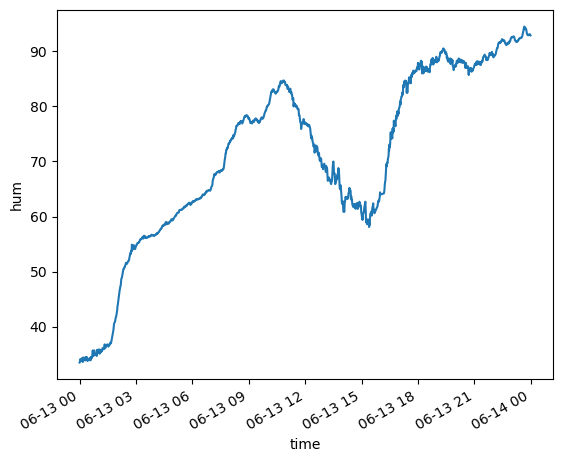

In [59]:
t13['hum'].plot()

:command_line = "sonde_ingest -s sgp -f C1" ;
		:Conventions = "ARM-1.2" ;
		:process_version = "ingest-sonde-10.14-1.el7" ;
		:dod_version = "sondewnpn-b1-2.3" ;
		:input_source = "/data/collection/sgp/sgpsondeC1.00/good.2023APR221134.parsed" ;
		:site_id = "sgp" ;
		:platform_id = "sondewnpn" ;
		:facility_id = "C1" ;
		:data_level = "b1" ;
		:location_description = "Southern Great Plains (SGP), Lamont, Oklahoma" ;
		:datastream = "sgpsondewnpnC1.b1" ;
		:sample_int = "1.2 seconds" ;
		:averaging_int = "None" ;
		:serial_number = "T2710383" ;
		:ingest_software = "ingest-sonde-10.14-1.el7" ;